# **0: Summary**

This notebook apply the Alexandre Ferreira Oliveira CNN code, where Leandro Veloso organize to a colab notebook with minor organization that does not change his finds.


leandrojpveloso@gmail.com
www.leandrojpveloso.com

# 1: Setting up Python

## 1.1: Basic package

In [ ]:
import matplotlib.pyplot as plt   # plotting
import numpy as np                # linear algebra
import pandas as pd               # data processing, CSV file I/O (e.g. pd.read_csv)
import os                         # accessing directory structure
import pickle                     # reading pickle files format
from google.colab import drive    # google drive conection
import seaborn as sns             # graph bar

In [ ]:
import pickle
from scipy import ndimage, misc
from   mpl_toolkits.mplot3d import Axes3D
from   glob import glob
from   tqdm import tqdm
import cv2 
import time
import sys, math

## 1.2: Tensorflow

In [ ]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
!pip install tensorflow-addons

In [ ]:
import tensorflow_addons as tfa

## 1.3: Keras

In [ ]:
import keras

## 1.4: Scikit packages

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

drive mounting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Alexandre's drive Path 
Alex_path = "/content/drive/MyDrive/00-desorganizado/Dataset"
Le_path   = "/content/drive/MyDrive/01-projetos_colab/03-PHd/01-Covid_lung_deep"

Mounted at /content/drive


# 2: CNN Model setting up

## 2.1: Creating model object

In [ ]:
CNN_model = keras.Sequential([
    keras.layers.Conv2D(80, kernel_size=3, activation='relu', input_shape=(256,256,1), padding='valid'),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=None),
    keras.layers.Conv2D(40, kernel_size=3, activation='relu', padding='valid'),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(3, activation=tf.nn.softmax)
])

In [ ]:
 CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 80)      800       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 80)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 40)      28840     
                                                                 
 global_average_pooling2d (G  (None, 40)               0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 30)                1

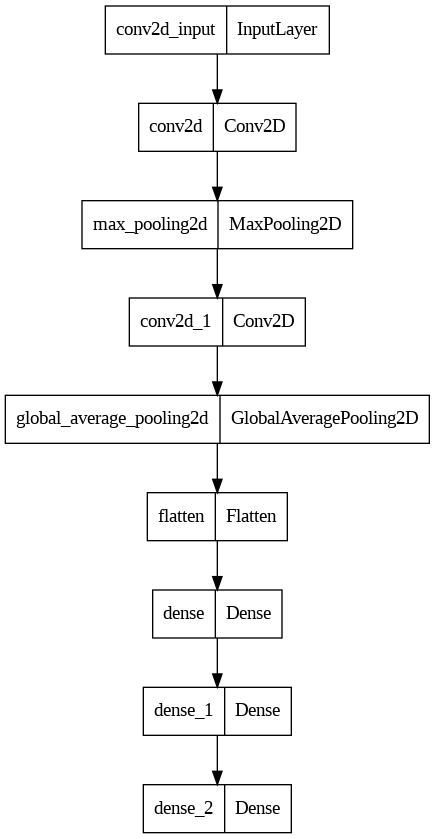

In [ ]:
tf.keras.utils.plot_model(CNN_model)

## 2.2 Compilation object definition

Aqui definimos o otimizador, a função de perda utilizada e as métricas consideradas para treinamento do modelo

In [ ]:
f1 = tfa.metrics.F1Score(num_classes=3, average='weighted')

In [ ]:
CNN_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy','AUC',f1])

f1 = tfa.metrics.F1Score(num_classes=3, average='weighted')

## 2.3: Adding callbacks

In [ ]:
es = EarlyStopping(monitor='val_f1_score', 
                   mode='max', 
                   verbose=1, 
                   patience=100)  

## 2.4: Defyning function to save model history

In [ ]:
root_logdir = os.path.join(Le_path, "01-log")

In [ ]:
def get_run_logdir():
    run_id = time.strftime("run_CNN_XeY_256_Weight_F1_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [ ]:
mc = ModelCheckpoint(os.path.join(root_logdir, '/RedeCNN_Tese_Full_F1.h5'), 
                     monitor='val_f1_score', 
                     mode='max', 
                     save_best_only=True,
                     verbose=1)

In [ ]:
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [ ]:
mc = ModelCheckpoint(os.path.join(run_logdir, 'RedeCNN_Tese_Full_F1.h5'), 
                     monitor='val_f1_score', 
                     mode='max', 
                     save_best_only=True,
                     verbose=1)

# 3: Preprocessing

## 3.1: Loading data

In [ ]:
# Loading gzip file
npzfile = np.load(Le_path + "/01_data/Img_X_Y.npz")

# Checking files inside zip file
npzfile.files

['X_img_numpy', 'Y_lab_numpy', 'df_pandas']

In [ ]:
# Reading it position
X = npzfile['X_img_numpy']
Y = npzfile['Y_lab_numpy']
IMG_df = pd.read_csv(Le_path + "/01_data"+'/01-lung-dataset-entry.csv')
print('Tamanho base de treino X',np.shape(X))
print('Tamanho base de treino Y',np.shape(Y))
print('Tamanho base de treino Y',np.shape(IMG_df))

Tamanho base de treino X (193419, 256, 256)
Tamanho base de treino Y (193419, 4)
Tamanho base de treino Y (193419, 15)


In [ ]:
Y_labels = np.delete(Y, 0, 1)

No preprocessing applyed in this situation

# 4: Training

## 4.1: Example cnn with 1 epoch

In [ ]:
epochs_set     = 1
batch_size_set = 32

In [ ]:
fold_test = 1
fold_val  = 2 

In [ ]:
treino_info = IMG_df[
    np.logical_not(
        IMG_df.Bin.isin(
            [fold_test, fold_val]
            )
       )
    ]  
treino_info.Bin.value_counts()

10    19498
6     19482
5     19431
7     19398
4     19327
3     19281
9     19232
8     19148
Name: Bin, dtype: int64

In [ ]:
# Selecting every index different of validation and training indexes
train_index =  np.logical_not(
     np.isin(Y[:,0],[fold_test, fold_val])
  )

# Selecting every index different of validation and training indexes
val_index =  np.isin(Y[:,0],[fold_val])

In [ ]:
def get_pesos(y_true): #taken from old keras source code
    valores_classes=y_true['class_covid'].value_counts()
#    print(valores_classes)
    multiplo_comum = (valores_classes[0]*valores_classes[1]*valores_classes[2])/(1000*1000*1000)
#    print(multiplo_comum)
    valor = (multiplo_comum/valores_classes)
    valor_total = np.sum(valor)
    return (valor/valor_total)

In [ ]:
testando_pesos=get_pesos(treino_info)
print(testando_pesos)

2:Covid-19     0.208505
0:Normal       0.314558
1:Pneumonia    0.476937
Name: class_covid, dtype: float64


In [ ]:
class_weight = {0 : testando_pesos[0], 1 : testando_pesos[1], 2 : testando_pesos[2]}
print(class_weight)

{0: 0.20850476230725787, 1: 0.31455798279149805, 2: 0.47693725490124417}


In [ ]:
batch_size_set = 32
epochs_set= 2

In [ ]:
CNN_model.fit(
          X[train_index], 
          Y_labels[train_index],
          validation_data=(X[val_index], Y_labels[val_index]),
          epochs=epochs_set,
          callbacks=[es,mc],
          batch_size=batch_size_set,
          validation_freq=1, 
          class_weight=class_weight)

Epoch 1/2
4837/4838 [============================>.] - ETA: 0s - loss: 0.0575 - accuracy: 0.9276 - auc: 0.9891 - f1_score: 0.9273
Epoch 1: val_f1_score did not improve from 0.93983
4838/4838 [==============================] - 90s 19ms/step - loss: 0.0575 - accuracy: 0.9276 - auc: 0.9891 - f1_score: 0.9273 - val_loss: 0.4303 - val_accuracy: 0.8396 - val_auc: 0.9623 - val_f1_score: 0.8253
Epoch 2/2
4837/4838 [============================>.] - ETA: 0s - loss: 0.0481 - accuracy: 0.9401 - auc: 0.9922 - f1_score: 0.9398
Epoch 2: val_f1_score improved from 0.93983 to 0.94757, saving model to /content/drive/MyDrive/01-projetos_colab/03-PHd/01-Covid_lung_deep/01-log/run_CNN_XeY_256_Weight_F1_2023_01_22-08_20_59/RedeCNN_Tese_Full_F1.h5
4838/4838 [==============================] - 88s 18ms/step - loss: 0.0482 - accuracy: 0.9401 - auc: 0.9922 - f1_score: 0.9398 - val_loss: 0.1537 - val_accuracy: 0.9476 - val_auc: 0.9922 - val_f1_score: 0.9476


In [ ]:
CNN_model.save(Le_path + "/03_fitted_models/CNN_example")

## 4.2: K-fold cross validation